In [1]:
import pandas as pd
import os
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from nltk.corpus import stopwords

In [2]:
# df = pd.read_csv('AnnotatedDocuments - Cases.tsv', sep='\t')
df = pd.read_csv('AnnotatedDocumentsMyEdits.tsv', sep='\t')
df.set_index('Case Name',inplace=True)
df.head(2)

,Offence,Outcome: SM,Outcome: Overall Verdict,Support,Prior case Influence,Platform,Evidence Type,Unnamed: 8
Case Name,,,,,,,,
People v Wells,Murder in the second degree; criminal possessi...,"However, the admission of the photographs was ...",Judgement is affirmed,We agree with the Supreme Court's determinatio...,People v Price ; People v Patterson; People v ...,Facebook; Instagram,Photographs,NaN
Pecile v Titan Capital Group,sexual harassment,Regarding defendants' demand for access to pla...,NaN,NaN,"Tapp v New York State Urban Dev. Corp.,",Social media,Posts,NaN


In [3]:
# df.loc[~df.index.isin(df.dropna(axis=0, how='all').index),:]

In [4]:
# does tha empty line mean anything?
df.dropna(axis=0, how='all',inplace=True)
print("Num cases annotated: ",len(df))
df.isnull().sum()

Num cases annotated:  39


Offence                      1
Outcome: SM                  7
Outcome: Overall Verdict     3
Support                      7
Prior case Influence         4
Platform                     4
Evidence Type                5
Unnamed: 8                  37
dtype: int64

In [5]:
# missing(NAN)[for 8] same as unspecified?
a= pd.DataFrame(df['Evidence Type'].str.strip().str.lower().str.split(';').dropna().tolist(), 
                index=df['Evidence Type'].str.strip().str.lower().str.split(';').dropna().index)
for col in a.columns:
    a[col]=a[col].str.strip()

b= pd.DataFrame(df['Platform'].str.strip().str.lower().str.split(';').dropna().tolist(), 
                index=df['Platform'].str.strip().str.lower().str.split(';').dropna().index)
for col in b.columns:
    b[col]=b[col].str.strip()
    
a.columns = ['evidence_'+str(col) for col in a.columns]
b.columns = ['platform_'+str(col) for col in b.columns]

print(len(a),len(b))
ev_plat = pd.concat([a,b], axis=1, sort=False)


34 35


In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts,stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def preprocess(df, custom_stopwords):
    docs_words = []
    for text in df.dropna():
        docs_words.append(gensim.utils.simple_preprocess(text, deacc=True))
        
    stop_words = stopwords.words('english')
    if len(custom_stopwords)>0:
        stop_words.extend(custom_stopwords)
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(docs_words, min_count=5, threshold=100) # higher threshold fewer phrases. 

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)

    # Remove Stop Words
    docs_words_nostops = remove_stopwords(docs_words, stop_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(docs_words_nostops, bigram_mod)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    # data_lemmatized = lemmatization(docs_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    data_lemmatized = lemmatization(data_words_bigrams, nlp, allowed_postags=['ADJ', 'VERB', 'ADV'])
    
    return data_lemmatized

In [42]:
df['all_text']=df['Outcome: SM']+' '+df['Support']+' '+df['Outcome: Overall Verdict']
fb_index = ev_plat.loc[(ev_plat.platform_0=='facebook') | (ev_plat.platform_1 == 'facebook') | (ev_plat.platform_2 == 'facebook'),:].index
mysps_index = ev_plat.loc[(ev_plat.platform_0=='myspace') | (ev_plat.platform_1 == 'myspace') | (ev_plat.platform_2 == 'myspace'),:].index

clean_data = preprocess(df.loc[:,'all_text'].dropna(), [])
clean_fb_data = preprocess(df.loc[fb_index,'all_text'].dropna(), [])
clean_mysps_data = preprocess(df.loc[mysps_index,'all_text'].dropna(), [])
alls = [item for sublist in clean_data for item in sublist]
all_fb = [item for sublist in clean_fb_data for item in sublist]
all_mysps = [item for sublist in clean_mysps_data for item in sublist]

In [43]:
from collections import Counter
all_counts = Counter(alls)
fb_counts = Counter(all_fb)
mysps_counts = Counter(all_mysps)
fb_counts.subtract(mysps_counts)

In [44]:
for k in fb_counts.keys():
#     print(fb_counts[k],all_counts[k])
    fb_counts[k] = fb_counts[k]/all_counts[k]

In [45]:
from operator import itemgetter
sorted(fb_counts.items(), key=itemgetter(1))
# ['facebook','defendant','complainant','myspace']
# Over emphasises rare words

[('adduce', -1.0),
 ('issue', -1.0),
 ('observe', -1.0),
 ('identify', -1.0),
 ('display', -1.0),
 ('several', -1.0),
 ('recognize', -1.0),
 ('examine', -1.0),
 ('appear', -1.0),
 ('blurry', -1.0),
 ('stand', -1.0),
 ('back', -1.0),
 ('random', -1.0),
 ('single', -1.0),
 ('eliminate', -1.0),
 ('suggestiveness', -1.0),
 ('suppress', -1.0),
 ('various', -1.0),
 ('fr', -1.0),
 ('deceptively', -1.0),
 ('supportive', -1.0),
 ('decline', -1.0),
 ('questionn', -1.0),
 ('feign', -1.0),
 ('voluntarily', -1.0),
 ('provide', -1.0),
 ('username', -1.0),
 ('verbally', -1.0),
 ('let', -1.0),
 ('impermissible', -1.0),
 ('fundamentally', -1.0),
 ('unfair', -1.0),
 ('deceptive', -1.0),
 ('gain', -1.0),
 ('subsequently', -1.0),
 ('review', -1.0),
 ('sign', -1.0),
 ('write', -1.0),
 ('spend', -1.0),
 ('await', -1.0),
 ('prejudicial', -1.0),
 ('unsupported', -1.0),
 ('instant', -1.0),
 ('slight', -1.0),
 ('refuse', -1.0),
 ('promise', -1.0),
 ('see', -1.0),
 ('pretty', -1.0),
 ('jog', -1.0),
 ('want', -1.

In [ ]:
from sklearn.feature_selection import chi2

In [99]: labels = []

In [100]: for fn in filenames:
   .....:     label = "Austen" if "Austen" in fn else "CBrontë"
   .....:     labels.append(label)
   .....: 

# chi2 returns two arrays, the chi2 test statistic and an
# array of "p-values", which we'll ignore
In [101]: keyness, _ = chi2(dtm, labels)

In [102]: ranking = np.argsort(keyness)[::-1]

In [103]: vocab[ranking][0:10]
Out[103]: 
array(['me', 'my', 'the', 'mr', 'mrs', 'elizabeth', 'be', 'and', 'very',
       'every'], 
      dtype='<U20')

# TODO: get dtm, calc chisq, see their differe

## Topic Modelling - All text

In [69]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['facebook','myspace','defendant','defendent','complainant','st','paul','post','posting','evidence','court','video','photo','photograph'])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(docs_words, min_count=5, threshold=100) # higher threshold fewer phrases. 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
docs_words_nostops = remove_stopwords(docs_words)

# Form Bigrams
data_words_bigrams = make_bigrams(docs_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(docs_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

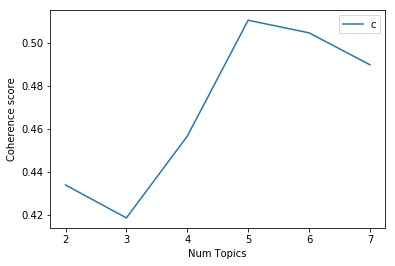

In [70]:
mallet_path = '/Users/rakshitanagalla/Desktop/SSW-Legal/mallet-2.0.8/bin/mallet'
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    For details, refer: 

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v') # try 'u_mass' too
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=8, step=1)
# Show graph
# limit=12; start=2; step=2;
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [71]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4337
Num Topics = 3  has Coherence Value of 0.4184
Num Topics = 4  has Coherence Value of 0.4565
Num Topics = 5  has Coherence Value of 0.5104
Num Topics = 6  has Coherence Value of 0.5046
Num Topics = 7  has Coherence Value of 0.4897


In [72]:
optimal_model = model_list[3]
# optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.060*"photo" + 0.046*"account" + 0.026*"case" + 0.026*"discretion" + '
  '0.026*"hearing" + 0.020*"girl" + 0.020*"support" + 0.020*"sex" + '
  '0.020*"statement" + 0.020*"conduct"'),
 (1,
  '0.044*"friend" + 0.044*"message" + 0.029*"motion" + 0.029*"juror" + '
  '0.029*"admit" + 0.029*"sufficient" + 0.022*"crime" + 0.022*"present" + '
  '0.022*"relationship" + 0.022*"access"'),
 (2,
  '0.062*"testimony" + 0.053*"witness" + 0.027*"exhibit" + 0.027*"make" + '
  '0.027*"consent" + 0.027*"akshar" + 0.027*"age" + 0.027*"complaintant" + '
  '0.018*"residence" + 0.018*"fail"'),
 (3,
  '0.042*"find" + 0.042*"testify" + 0.035*"law" + 0.035*"search" + '
  '0.028*"trial" + 0.028*"warrant" + 0.021*"threaten" + 0.021*"officer" + '
  '0.021*"show" + 0.021*"time"'),
 (4,
  '0.027*"send" + 0.027*"record" + 0.027*"family" + 0.027*"post" + '
  '0.027*"page" + 0.020*"violate" + 0.020*"staff" + 0.020*"photograph" + '
  '0.020*"nursing" + 0.020*"request"')]


In [73]:
state_file = optimal_model.fstate()
print(state_file)
from process_pyldaviz import get_pyldaviz
lda_prop = get_pyldaviz(state_file)
vis_data = pyLDAvis.prepare(**lda_prop)
pyLDAvis.display(vis_data)

/var/folders/8g/1g347k696y56fdzqtj5x54cr0000gn/T/2ca244_state.mallet.gz
[10.0, 10.0, 10.0, 10.0, 10.0], 0.01


//anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [ ]:
pyLDAvis.save_html(vis_data,'support.html')

## Outcome: SM

In [74]:
df.columns

Index(['Offence', 'Outcome: SM', 'Outcome: Overall Verdict', 'Support',
       'Prior case Influence', 'Platform', 'Evidence Type', 'Unnamed: 8'],
      dtype='object')

In [75]:
# what is SORA?
import gensim
docs_words = []
for text in df['Outcome: SM'].dropna():
    docs_words.append(gensim.utils.simple_preprocess(text, deacc=True))
ids_outcome = df['Outcome: SM'].dropna().index
len(docs_words)

31

In [84]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['facebook','myspace','defendant','defendent','complainant'])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(docs_words, min_count=5, threshold=100) # higher threshold fewer phrases. 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
docs_words_nostops = remove_stopwords(docs_words)

# Form Bigrams
data_words_bigrams = make_bigrams(docs_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(docs_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

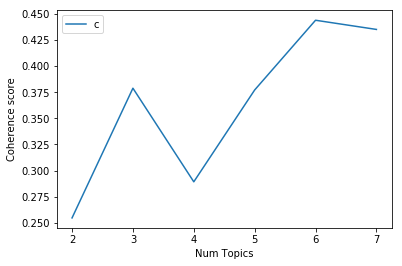

In [85]:
mallet_path = '/Users/rakshitanagalla/Desktop/SSW-Legal/mallet-2.0.8/bin/mallet'
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    For details, refer: 

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v') # try 'u_mass' too
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=8, step=1)
# Show graph
# limit=12; start=2; step=2;
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [86]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2546
Num Topics = 3  has Coherence Value of 0.3788
Num Topics = 4  has Coherence Value of 0.2892
Num Topics = 5  has Coherence Value of 0.3771
Num Topics = 6  has Coherence Value of 0.4439
Num Topics = 7  has Coherence Value of 0.4351


In [87]:
optimal_model = model_list[4]
# optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=6, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.091*"video" + 0.080*"victim" + 0.057*"include" + 0.034*"basis" + '
  '0.034*"record" + 0.034*"base" + 0.023*"paragraph" + 0.023*"social" + '
  '0.023*"local" + 0.023*"victm"'),
 (1,
  '0.064*"motion" + 0.064*"juror" + 0.038*"instruction" + 0.038*"obtain" + '
  '0.026*"issue" + 0.026*"rule" + 0.026*"website" + 0.026*"admit" + '
  '0.026*"stipulation" + 0.026*"photograph"'),
 (2,
  '0.067*"post" + 0.067*"claim" + 0.038*"support" + 0.029*"order" + '
  '0.029*"site" + 0.029*"child" + 0.029*"page" + 0.029*"employee" + '
  '0.029*"student" + 0.029*"staff"'),
 (3,
  '0.086*"court" + 0.049*"deny" + 0.049*"medium" + 0.049*"give" + 0.037*"gang" '
  '+ 0.037*"plaintiff" + 0.037*"people" + 0.037*"specific" + 0.025*"federal" + '
  '0.025*"fail"'),
 (4,
  '0.079*"message" + 0.067*"witness" + 0.056*"photograph" + 0.045*"account" + '
  '0.034*"police" + 0.034*"sex" + 0.034*"charge" + 0.022*"hearing" + '
  '0.022*"failure" + 0.022*"uploaded"'),
 (5,
  '0.163*"evidence" + 0.054*"social" + 0.04

In [88]:
state_file = optimal_model.fstate()
print(state_file)
from process_pyldaviz import get_pyldaviz
lda_prop = get_pyldaviz(state_file)
vis_data = pyLDAvis.prepare(**lda_prop)
pyLDAvis.display(vis_data)

/var/folders/8g/1g347k696y56fdzqtj5x54cr0000gn/T/4a84ed_state.mallet.gz
[8.333333333333334, 8.333333333333334, 8.333333333333334, 8.333333333333334, 8.333333333333334, 8.333333333333334], 0.01


//anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [89]:
pyLDAvis.save_html(vis_data,'support.html')

In [92]:
# df['Offence'] -> create vague categories

In [ ]:
# 